# Accurate Meal Model (Reversal Sessions)

This notebook revisits the reversal meal classification workflow. We gather meals directly from the current FED3 session interface, inspect clusters by pellet count, and evaluate pre-trained LSTM/CNN classifiers.

In [2]:
import numpy as np

from scripts.preprocessing import build_session_catalog, session_cache
from scripts.meals import analyze_meals
from scripts.meal_classifiers import (
    RNNClassifier,
    CNNClassifier,
    TimeSeriesDataset,
    train,
    evaluate_meals_by_groups,
    evaluate_meals_on_new_data,
)
from scripts.unsupervised_helpers import (
    find_k_by_elbow,
    fit_model_single,
    collect_meals_from_categories,
    data_padding,
    read_data,
    update_data,
    extract_meal_sequences,
)

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Load reversal sessions

In [3]:
SAMPLE_ROOT = 'sample_data'
GROUP_MAP_PATH = 'group_map.json'

session_cache.cache_clear()
SESSIONS, GROUPINGS = build_session_catalog(SAMPLE_ROOT, GROUP_MAP_PATH)

REV_SESSIONS = {}
for group, session_types in GROUPINGS.items():
    rev_keys = session_types.get('REV', [])
    rev_ids = [key.session_id for key in rev_keys]
    if rev_ids:
        REV_SESSIONS[group] = [SESSIONS[sid] for sid in rev_ids]

if not REV_SESSIONS:
    raise RuntimeError('No reversal sessions found. Ensure sample data includes REV sessions.')

GROUP_NAMES = sorted(REV_SESSIONS.keys())
GROUP_NAMES

['cask', 'ctrl', 'female']

## Extract meal sequences per group

In [4]:
control_group = GROUP_NAMES[0]
experiment_group = GROUP_NAMES[1]
validation_group = GROUP_NAMES[2]

ctrl_sequences, ctrl_good_ratios = extract_meal_sequences(REV_SESSIONS[control_group])
exp_sequences, exp_good_ratios = extract_meal_sequences(REV_SESSIONS[experiment_group])
val_sequences, val_good_ratios = extract_meal_sequences(REV_SESSIONS[validation_group])
summary = {
    control_group: {
        'n_sessions': len(ctrl_good_ratios),
        'mean': float(np.mean(ctrl_good_ratios)) if ctrl_good_ratios else 0.0,
        'std': float(np.std(ctrl_good_ratios)) if ctrl_good_ratios else 0.0,
    },
    experiment_group: {
        'n_sessions': len(exp_good_ratios),
        'mean': float(np.mean(exp_good_ratios)) if exp_good_ratios else 0.0,
        'std': float(np.std(exp_good_ratios)) if exp_good_ratios else 0.0,
    },
    validation_group: {
        'n_sessions': len(val_good_ratios),
        'mean': float(np.mean(val_good_ratios)) if val_good_ratios else 0.0,
        'std': float(np.std(val_good_ratios)) if val_good_ratios else 0.0,
    },
}
summary

{'cask': {'n_sessions': 24,
  'mean': 0.42476777623516204,
  'std': 0.14987902013430052},
 'ctrl': {'n_sessions': 27,
  'mean': 0.5645757889607254,
  'std': 0.12917616416026306},
 'female': {'n_sessions': 20,
  'mean': 0.47854283372930295,
  'std': 0.09688055432450716}}

## Control group clustering

We'll process each pellet count (3, 4, 5) separately in 3 steps:
1. Find optimal k using elbow method
2. Fit model and inspect clusters (Silhouette score + sample data)
3. Collect good/bad meals and save to disk

In [5]:
DATA_DIR = 'data'

### Control: 3-pellet meals

**Step 1:** Find optimal k using elbow method


Control 3-pellet meals: 645 samples


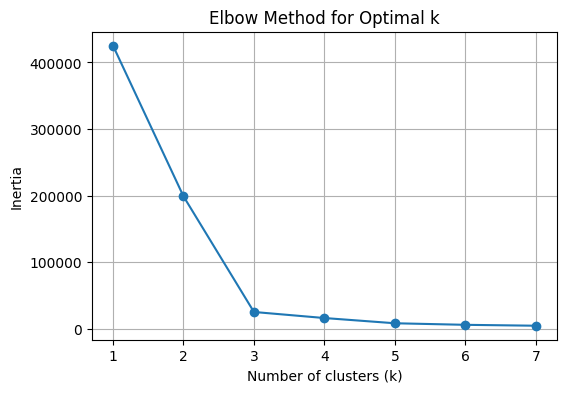

In [6]:
pellet_cnt = 3
ctrl_3_data = ctrl_sequences.get(pellet_cnt, [])
print(f"Control {pellet_cnt}-pellet meals: {len(ctrl_3_data)} samples")
if ctrl_3_data:
    find_k_by_elbow(ctrl_3_data)


**Step 2:** Fit model with chosen k and inspect clusters


In [7]:
# Set k based on elbow plot inspection
k = 4  # Placeholder - adjust based on Step 1 results

ctrl_3_model, ctrl_3_meals_by_category = fit_model_single(ctrl_3_data, k=k)

# Inspect first few elements in each cluster to decide which are "good"
print("\nCluster inspection (first 5-10 elements):")
for cluster_id, meals in ctrl_3_meals_by_category.items():
    print(f"\nCluster {cluster_id}: {len(meals)} meals")
    print(f"Sample data (first 5):")
    for i, meal in enumerate(meals[:5]):
        print(f"  Meal {i}: {meal[:10]}...")  # Show first 10 values


Silhouette Score: 0.9263877118693712

Cluster inspection (first 5-10 elements):

Cluster 0: 431 meals
Sample data (first 5):
  Meal 0: [100. 100.]...
  Meal 1: [100. 100.]...
  Meal 2: [100. 100.]...
  Meal 3: [100. 100.]...
  Meal 4: [100. 100.]...

Cluster 1: 76 meals
Sample data (first 5):
  Meal 0: [ 50. 100.]...
  Meal 1: [ 50. 100.]...
  Meal 2: [ 50. 100.]...
  Meal 3: [ 50. 100.]...
  Meal 4: [ 50. 100.]...

Cluster 2: 107 meals
Sample data (first 5):
  Meal 0: [100.  50.]...
  Meal 1: [100.  50.]...
  Meal 2: [100.  50.]...
  Meal 3: [100.  50.]...
  Meal 4: [100.  50.]...

Cluster 3: 31 meals
Sample data (first 5):
  Meal 0: [100.  75.]...
  Meal 1: [100.          79.16666667]...
  Meal 2: [100.          66.66666667]...
  Meal 3: [100.  80.]...
  Meal 4: [100.          77.77777778]...


**Step 3:** Collect good/bad meals and save


In [ ]:
# Set good_clusters based on Step 2 inspection
good_clusters = [0, 3]  # Placeholder - adjust based on cluster inspection

ctrl_3_good, ctrl_3_bad = collect_meals_from_categories(ctrl_3_meals_by_category, good_clusters)
print(f"Good meals: {len(ctrl_3_good)}, Bad meals: {len(ctrl_3_bad)}")

# Save to disk
update_data(DATA_DIR + '/CASK_ctrl_good.pkl', ctrl_3_good)
update_data(DATA_DIR + '/CASK_ctrl_bad.pkl', ctrl_3_bad)

Good meals: 462, Bad meals: 183
Old data has 463 items
New data has 925 items
Old data has 360 items
New data has 543 items


### Control: 4-pellet meals

**Step 1:** Find optimal k using elbow method

In [ ]:
pellet_cnt = 4
ctrl_4_data = ctrl_sequences.get(pellet_cnt, [])
print(f"Control {pellet_cnt}-pellet meals: {len(ctrl_4_data)} samples")
if ctrl_4_data:
    find_k_by_elbow(ctrl_4_data)

**Step 2:** Fit model with chosen k and inspect clusters

In [ ]:
# Set k based on elbow plot inspection
k = 7  # Placeholder - adjust based on Step 1 results

ctrl_4_model, ctrl_4_meals_by_category = fit_model_single(ctrl_4_data, k=k)

# Inspect first few elements in each cluster to decide which are "good"
print("\nCluster inspection (first 5-10 elements):")
for cluster_id, meals in ctrl_4_meals_by_category.items():
    print(f"\nCluster {cluster_id}: {len(meals)} meals")
    print(f"Sample data (first 5):")
    for i, meal in enumerate(meals[:5]):
        print(f"  Meal {i}: {meal[:10]}...")  # Show first 10 values

**Step 3:** Collect good/bad meals and save

In [ ]:
# Set good_clusters based on Step 2 inspection
good_clusters = [1, 4]  # Placeholder - adjust based on cluster inspection

ctrl_4_good, ctrl_4_bad = collect_meals_from_categories(ctrl_4_meals_by_category, good_clusters)
print(f"Good meals: {len(ctrl_4_good)}, Bad meals: {len(ctrl_4_bad)}")

# Save to disk (appending to existing files)
update_data(DATA_DIR + '/CASK_ctrl_good.pkl', ctrl_4_good)
update_data(DATA_DIR + '/CASK_ctrl_bad.pkl', ctrl_4_bad)

### Control: 5-pellet meals

**Step 1:** Find optimal k using elbow method

In [ ]:
pellet_cnt = 5
ctrl_5_data = ctrl_sequences.get(pellet_cnt, [])
print(f"Control {pellet_cnt}-pellet meals: {len(ctrl_5_data)} samples")
if ctrl_5_data:
    find_k_by_elbow(ctrl_5_data)

**Step 2:** Fit model with chosen k and inspect clusters

In [ ]:
# Set k based on elbow plot inspection
k = 8  # Placeholder - adjust based on Step 1 results

ctrl_5_model, ctrl_5_meals_by_category = fit_model_single(ctrl_5_data, k=k)

# Inspect first few elements in each cluster to decide which are "good"
print("\nCluster inspection (first 5-10 elements):")
for cluster_id, meals in ctrl_5_meals_by_category.items():
    print(f"\nCluster {cluster_id}: {len(meals)} meals")
    print(f"Sample data (first 5):")
    for i, meal in enumerate(meals[:5]):
        print(f"  Meal {i}: {meal[:10]}...")  # Show first 10 values

**Step 3:** Collect good/bad meals and save

In [ ]:
# Set good_clusters based on Step 2 inspection
good_clusters = [1, 3, 7]  # Placeholder - adjust based on cluster inspection

ctrl_5_good, ctrl_5_bad = collect_meals_from_categories(ctrl_5_meals_by_category, good_clusters)
print(f"Good meals: {len(ctrl_5_good)}, Bad meals: {len(ctrl_5_bad)}")

# Save to disk (appending to existing files)
update_data(DATA_DIR + '/CASK_ctrl_good.pkl', ctrl_5_good)
update_data(DATA_DIR + '/CASK_ctrl_bad.pkl', ctrl_5_bad)

## Experimental group clustering

We'll process each pellet count (3, 4, 5) separately in 3 steps:
1. Find optimal k using elbow method
2. Fit model and inspect clusters (Silhouette score + sample data)
3. Collect good/bad meals and save to disk

### Experimental: 3-pellet meals
Experimental group will follow the same pattern as control group

**Step 1:** Find optimal k using elbow method

In [ ]:
pellet_cnt = 3
exp_3_data = exp_sequences.get(pellet_cnt, [])
print(f"Experimental {pellet_cnt}-pellet meals: {len(exp_3_data)} samples")
if exp_3_data:
    find_k_by_elbow(exp_3_data)

**Step 2:** Fit model with chosen k and inspect clusters

In [ ]:
# Set k based on elbow plot inspection
k = 6  # Placeholder - adjust based on Step 1 results

exp_3_model, exp_3_meals_by_category = fit_model_single(exp_3_data, k=k)

# Inspect first few elements in each cluster to decide which are "good"
print("\nCluster inspection (first 5-10 elements):")
for cluster_id, meals in exp_3_meals_by_category.items():
    print(f"\nCluster {cluster_id}: {len(meals)} meals")
    print(f"Sample data (first 5):")
    for i, meal in enumerate(meals[:5]):
        print(f"  Meal {i}: {meal[:10]}...")  # Show first 10 values

**Step 3:** Collect good/bad meals and save

In [ ]:
# Set good_clusters based on Step 2 inspection
good_clusters = [0, 3]  # Placeholder - adjust based on cluster inspection

exp_3_good, exp_3_bad = collect_meals_from_categories(exp_3_meals_by_category, good_clusters)
print(f"Good meals: {len(exp_3_good)}, Bad meals: {len(exp_3_bad)}")

# Save to disk
update_data(DATA_DIR + '/CASK_exp_good.pkl', exp_3_good)
update_data(DATA_DIR + '/CASK_exp_bad.pkl', exp_3_bad)

### Experimental: 4-pellet meals

**Step 1:** Find optimal k using elbow method

In [ ]:
pellet_cnt = 4
exp_4_data = exp_sequences.get(pellet_cnt, [])
print(f"Experimental {pellet_cnt}-pellet meals: {len(exp_4_data)} samples")
if exp_4_data:
    find_k_by_elbow(exp_4_data)

**Step 2:** Fit model with chosen k and inspect clusters

In [ ]:
# Set k based on elbow plot inspection
k = 9  # Placeholder - adjust based on Step 1 results

exp_4_model, exp_4_meals_by_category = fit_model_single(exp_4_data, k=k)

# Inspect first few elements in each cluster to decide which are "good"
print("\nCluster inspection (first 5-10 elements):")
for cluster_id, meals in exp_4_meals_by_category.items():
    print(f"\nCluster {cluster_id}: {len(meals)} meals")
    print(f"Sample data (first 5):")
    for i, meal in enumerate(meals[:5]):
        print(f"  Meal {i}: {meal[:10]}...")  # Show first 10 values

**Step 3:** Collect good/bad meals and save

In [ ]:
# Set good_clusters based on Step 2 inspection
good_clusters = [2, 6]  # Placeholder - adjust based on cluster inspection

exp_4_good, exp_4_bad = collect_meals_from_categories(exp_4_meals_by_category, good_clusters)
print(f"Good meals: {len(exp_4_good)}, Bad meals: {len(exp_4_bad)}")

# Save to disk (appending to existing files)
update_data(DATA_DIR + '/CASK_exp_good.pkl', exp_4_good)
update_data(DATA_DIR + '/CASK_exp_bad.pkl', exp_4_bad)

### Experimental: 5-pellet meals

**Step 1:** Find optimal k using elbow method

In [ ]:
pellet_cnt = 5
exp_5_data = exp_sequences.get(pellet_cnt, [])
print(f"Experimental {pellet_cnt}-pellet meals: {len(exp_5_data)} samples")
if exp_5_data:
    find_k_by_elbow(exp_5_data)

**Step 2:** Fit model with chosen k and inspect clusters

In [ ]:
# Set k based on elbow plot inspection
k = 12  # Placeholder - adjust based on Step 1 results

exp_5_model, exp_5_meals_by_category = fit_model_single(exp_5_data, k=k)

# Inspect first few elements in each cluster to decide which are "good"
print("\nCluster inspection (first 5-10 elements):")
for cluster_id, meals in exp_5_meals_by_category.items():
    print(f"\nCluster {cluster_id}: {len(meals)} meals")
    print(f"Sample data (first 5):")
    for i, meal in enumerate(meals[:5]):
        print(f"  Meal {i}: {meal[:10]}...")  # Show first 10 values


**Step 3:** Collect good/bad meals and save

In [ ]:
# Set good_clusters based on Step 2 inspection
good_clusters = [1, 3, 6]  # Placeholder - adjust based on cluster inspection

exp_5_good, exp_5_bad = collect_meals_from_categories(exp_5_meals_by_category, good_clusters)
print(f"Good meals: {len(exp_5_good)}, Bad meals: {len(exp_5_bad)}")

# Save to disk (appending to existing files)
update_data(DATA_DIR + '/CASK_exp_good.pkl', exp_5_good)
update_data(DATA_DIR + '/CASK_exp_bad.pkl', exp_5_bad)

## Prepare datasets for modelling

In [ ]:
ctrl_good = read_data(DATA_DIR + '/CASK_ctrl_good.pkl')
ctrl_bad = read_data(DATA_DIR + '/CASK_ctrl_bad.pkl')
exp_good = read_data(DATA_DIR + '/CASK_exp_good.pkl')
exp_bad = read_data(DATA_DIR + '/CASK_exp_bad.pkl')

print(f'Control labelled meals: good={len(ctrl_good)}, bad={len(ctrl_bad)}')
print(f'Experiment labelled meals: good={len(exp_good)}, bad={len(exp_bad)}')

ctrl_X = np.vstack((data_padding([meal[:] for meal in ctrl_good]), data_padding([meal[:] for meal in ctrl_bad])))
ctrl_y = np.concatenate((np.zeros(len(ctrl_good)), np.ones(len(ctrl_bad))))
exp_X = np.vstack((data_padding([meal[:] for meal in exp_good]), data_padding([meal[:] for meal in exp_bad])))
exp_y = np.concatenate((np.zeros(len(exp_good)), np.ones(len(exp_bad))))

X = np.vstack((ctrl_X, exp_X))
y = np.concatenate((ctrl_y, exp_y))
print('Dataset shape:', X.shape)

## Train LSTM/CNN classifiers

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, shuffle=True, random_state=42)

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

rnn_model = RNNClassifier(input_size=1, hidden_size=400, num_layers=2, num_classes=2)
rnn_model = rnn_model.to(X_train.device)
rnn_model = train(rnn_model, lr=1e-4, num_epochs=50, train_loader=train_loader, X_test_tensor=X_test, y_test_tensor=y_test)

cnn_model = CNNClassifier(num_classes=2, maxlen=X.shape[1])
cnn_model = cnn_model.to(X_train.device)
cnn_model = train(cnn_model, lr=1e-3, num_epochs=50, train_loader=train_loader, X_test_tensor=X_test, y_test_tensor=y_test)

## Evaluate pre-trained models

In [ ]:
ctrl_tensor = torch.tensor(ctrl_X, dtype=torch.float32)
ctrl_labels = torch.tensor(ctrl_y, dtype=torch.long)
exp_tensor = torch.tensor(exp_X, dtype=torch.float32)
exp_labels = torch.tensor(exp_y, dtype=torch.long)

rnn_pretrained = RNNClassifier(input_size=1, hidden_size=400, num_layers=2, num_classes=2)
cnn_pretrained = CNNClassifier(num_classes=2, maxlen=ctrl_X.shape[1])

rnn_pretrained.load_state_dict(torch.load(DATA_DIR + '/LSTM_from_CASK.pth', map_location='cpu'))
cnn_pretrained.load_state_dict(torch.load(DATA_DIR + '/CNN_from_CASK.pth', map_location='cpu'))

print('Pre-trained RNN evaluation:')
evaluate_meals_by_groups(rnn_pretrained, ctrl_tensor, ctrl_y, exp_tensor, exp_y)
print('Pre-trained CNN evaluation:')
evaluate_meals_by_groups(cnn_pretrained, ctrl_tensor, ctrl_y, exp_tensor, exp_y)